# Loading Dataset

In [41]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from itertools import combinations
import networkx as nx

import matplotlib.cm as cm
from nltk import ngrams
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jie22\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jie22\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Creating a conglomerate wordcloud which uses sentences from all datasets
product_list= ['apex_ad2600_dvd_player_updated', 'canon_g3_updated', 'nikon_coolpix_4300_updated', 'nokia_6610_updated', 'nomad_jukebox_zen_xtra_updated']
shortened_product_names = {
    "apex_ad2600_dvd_player_updated": "Apex DVD-Player",
    "canon_g3_updated": "Canon Camera",
    "nikon_coolpix_4300_updated": "Nikon Camera",
    "nokia_6610_updated": "Nokia Phone",
    "nomad_jukebox_zen_xtra_updated": "Nomad MP3-Player",
}

def load_bunch() -> dict[pd.DataFrame]:
    apex = pd.read_csv('processed_data/apex_ad2600_dvd_player_updated.csv')
    canon = pd.read_csv('processed_data/canon_g3_updated.csv')
    nikon = pd.read_csv('processed_data/nikon_coolpix_4300_updated.csv')
    nokia = pd.read_csv('processed_data/nokia_6610_updated.csv')
    nomad = pd.read_csv('processed_data/nomad_jukebox_zen_xtra_updated.csv')
    return {
        "apex_ad2600_dvd_player_updated": apex,
        "canon_g3_updated": canon,
        "nikon_coolpix_4300_updated": nikon,
        "nokia_6610_updated": nokia,
        "nomad_jukebox_zen_xtra_updated": nomad
    }
bunch = load_bunch()
master_df = pd.concat(bunch.values(), ignore_index=True)

# Additional Preprocessing

Some additional preprocessing is done for different types of analysis. For specific lines of analysis we want to look at different filtered versions of tokens. 

In [12]:
def preprocess_text(text, remove_stopwords: bool = True):
    tokens = word_tokenize(text)

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    return tokens
def flatten(list):
    return [item for sublist in list for item in sublist]

# product_list = ['apex_ad2600_dvd_player_updated', 'canon_g3_updated', 'nikon_coolpix_4300_updated', 'nokia_6610_updated', 'nomad_jukebox_zen_xtra_updated']
preprocessed_data_no_stopwords = {}
preprocessed_data_with_stopwords = {}
for product in product_list:
    preprocessed_data_no_stopwords[product] = [preprocess_text(str(text), remove_stopwords = True) for text in bunch[product]['sentence']]
    preprocessed_data_no_stopwords[product] = flatten(preprocessed_data_no_stopwords[product])
    preprocessed_data_with_stopwords[product] = [preprocess_text(str(text), remove_stopwords = True) for text in bunch[product]['sentence']]
    preprocessed_data_with_stopwords[product] = flatten(preprocessed_data_with_stopwords[product])

### Functions for Wordcloud

In [42]:
def create_wordcloud(preprocessed_data: list[str], title: str = None, ax: plt.Axes = None, **kwargs) -> None:
    text_data = " ".join(preprocessed_data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', **kwargs).generate(text_data)

    if ax is not None:
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        if title is not None:
            ax.set_title(title)

    else:
        plt.figure(figsize=(10, 5))
        if title is not None:
            plt.title(title, fontsize=16)
        else:
            plt.title("Word Cloud for 'sentence' Column", fontsize=16)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')

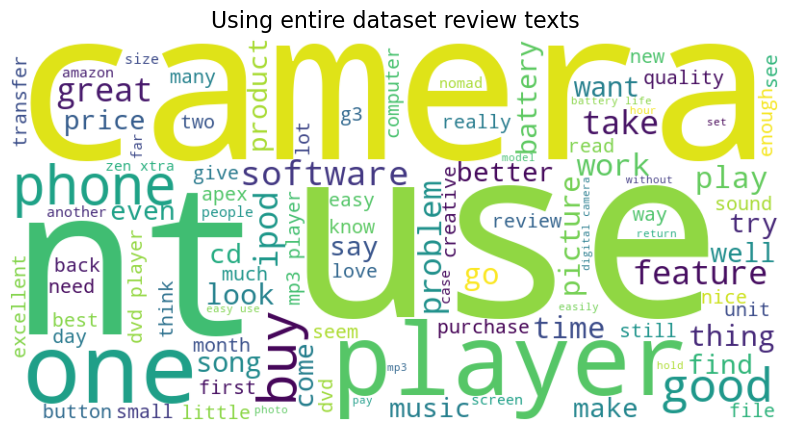

In [43]:
preprocessed_data_with_stopwords_total = [
    preprocess_text(str(text), remove_stopwords=True) for text in master_df["sentence"]
]
preprocessed_data_with_stopwords_total = flatten(preprocessed_data_with_stopwords_total)

create_wordcloud(preprocessed_data_with_stopwords_total, title="Using entire dataset review texts", max_words=100)

##### With Stopwords

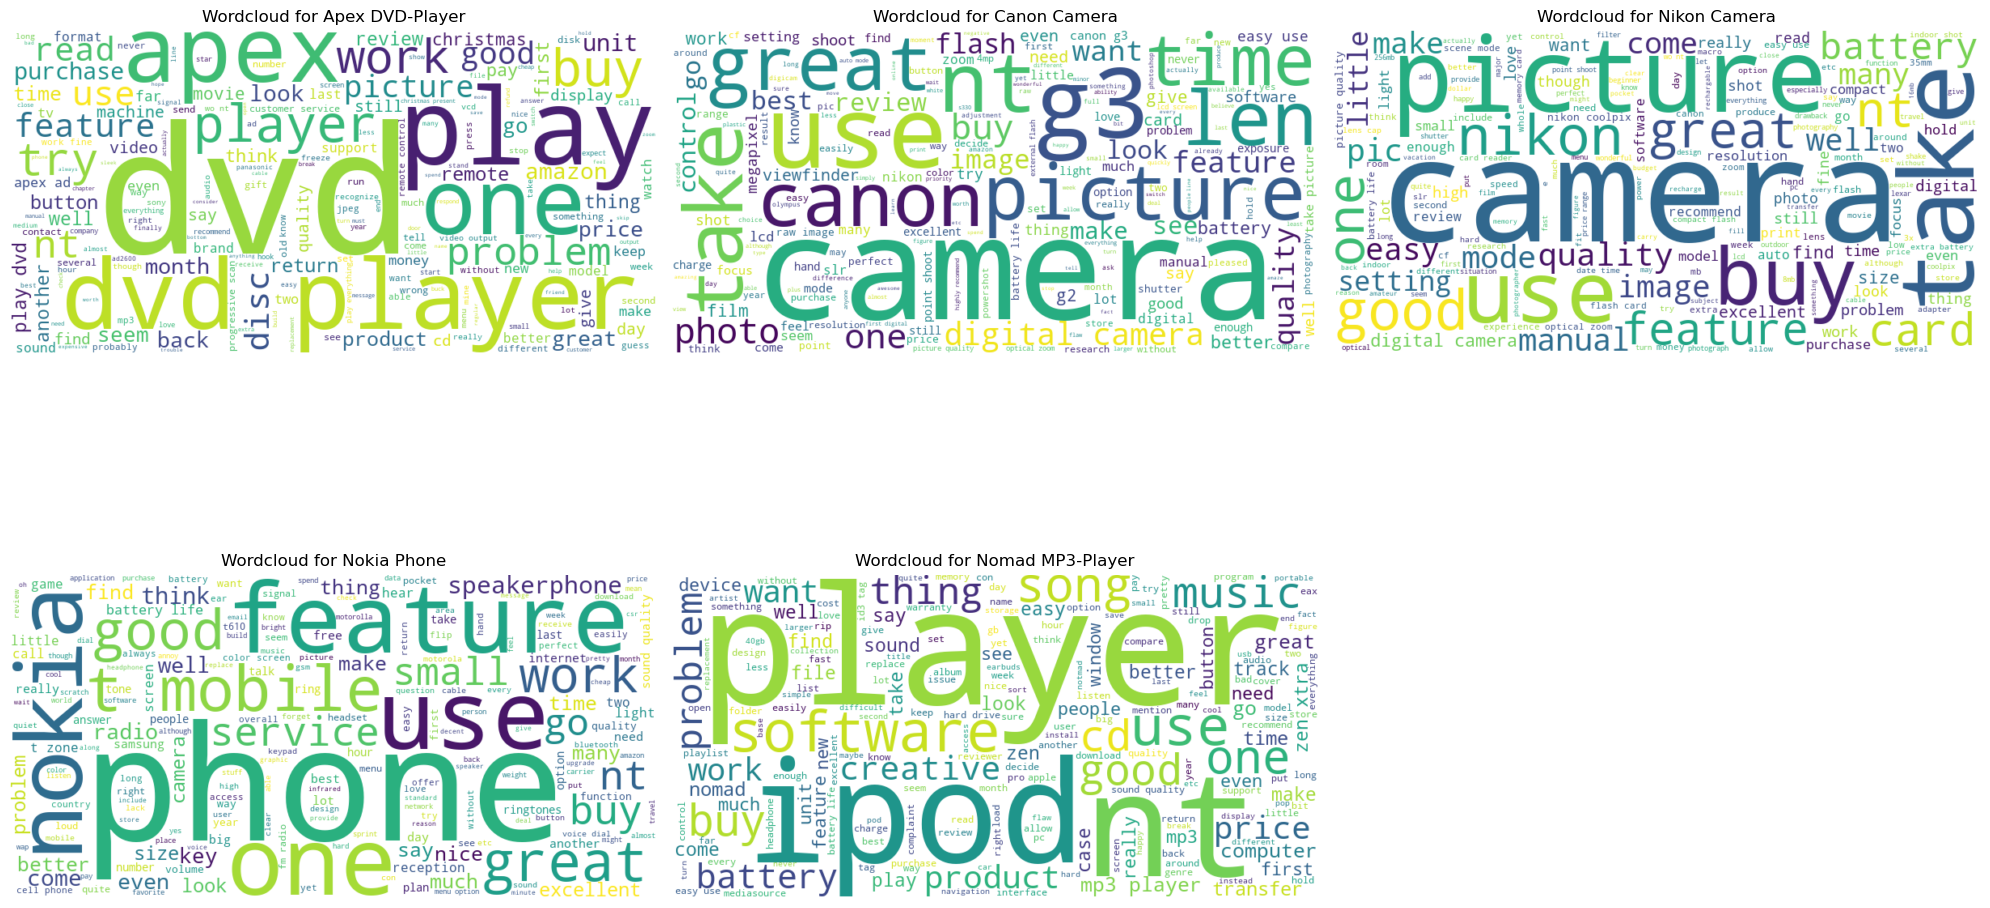

In [45]:
def plot_product_wordclouds(remove_stopwords: bool, feature_name: str = 'sentence'):
    _, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes: list[plt.Axes] = axes.ravel()
    for i, product in enumerate(product_list):
        if remove_stopwords:
            create_wordcloud(preprocessed_data_no_stopwords[product], title=f"Wordcloud for {shortened_product_names[product]}" , ax=axes[i])
        else:
            create_wordcloud(preprocessed_data_with_stopwords[product], title=f"Wordcloud for {shortened_product_names[product]}", ax=axes[i])
    axes[5].remove()

plot_product_wordclouds(remove_stopwords = False)

plt.tight_layout()
plt.show()

##### Without Stopwords

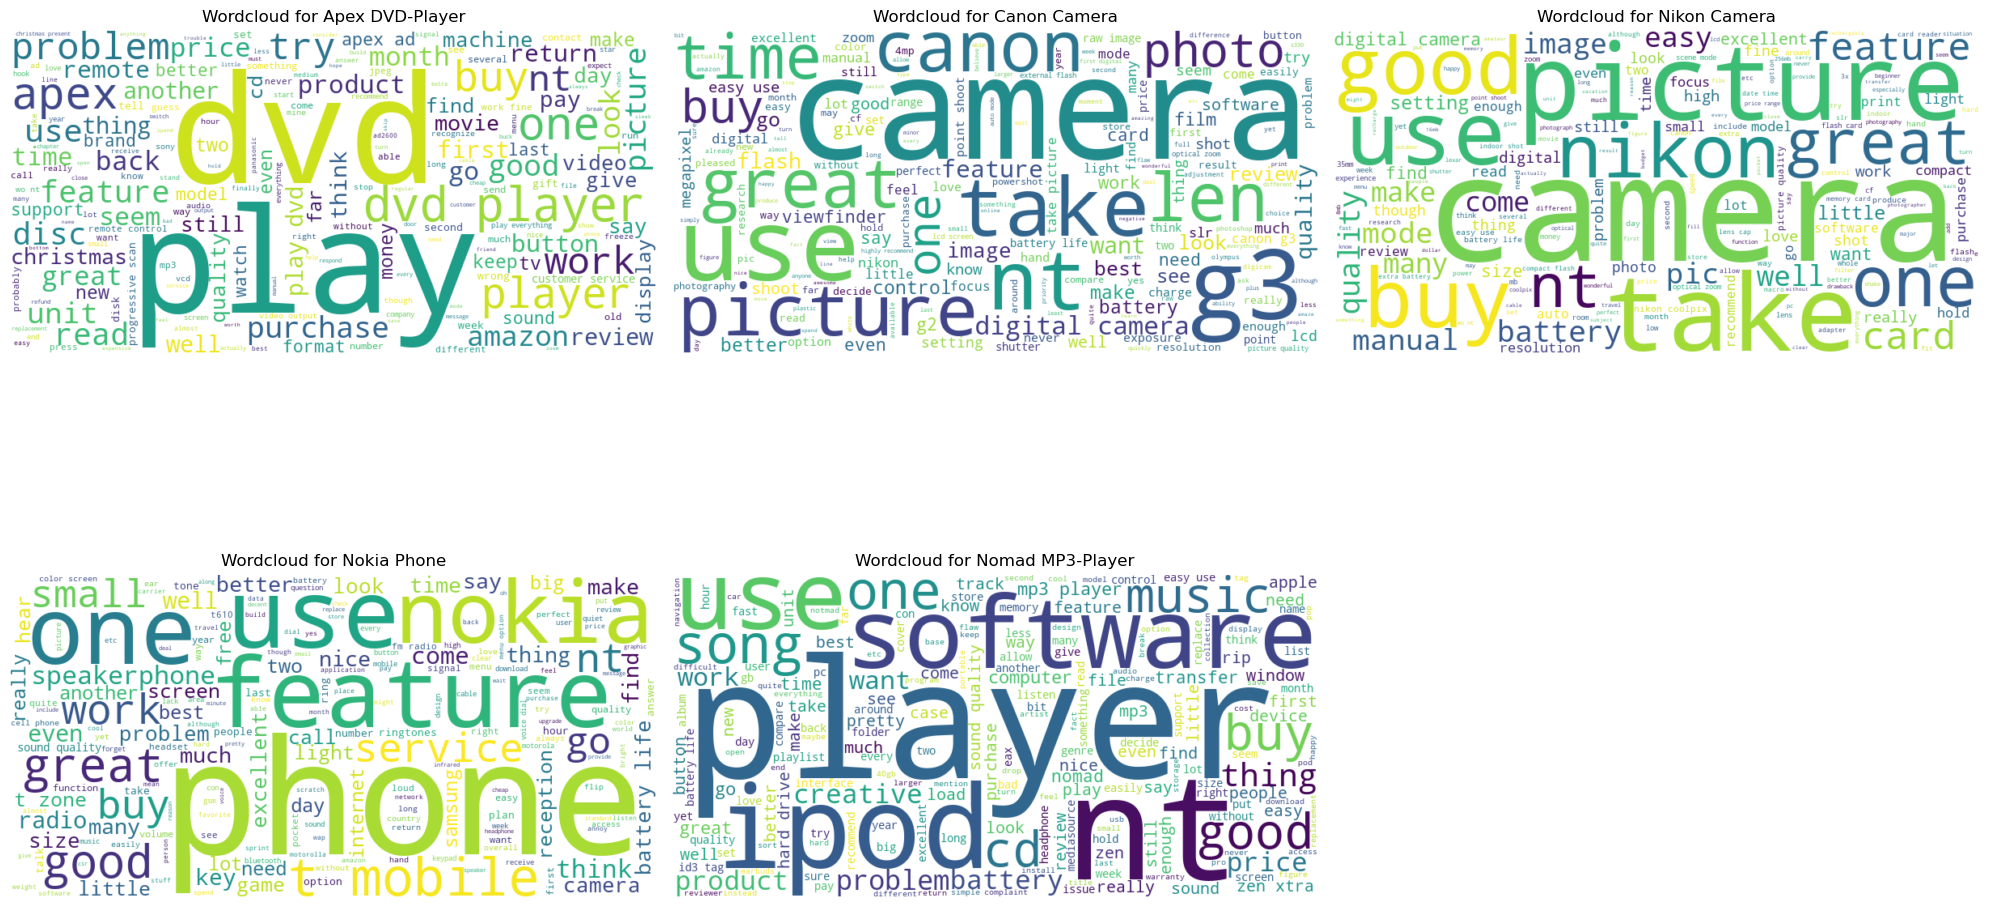

In [46]:
plot_product_wordclouds(remove_stopwords = True)
plt.tight_layout()
plt.show()

##### Wordcount of Title

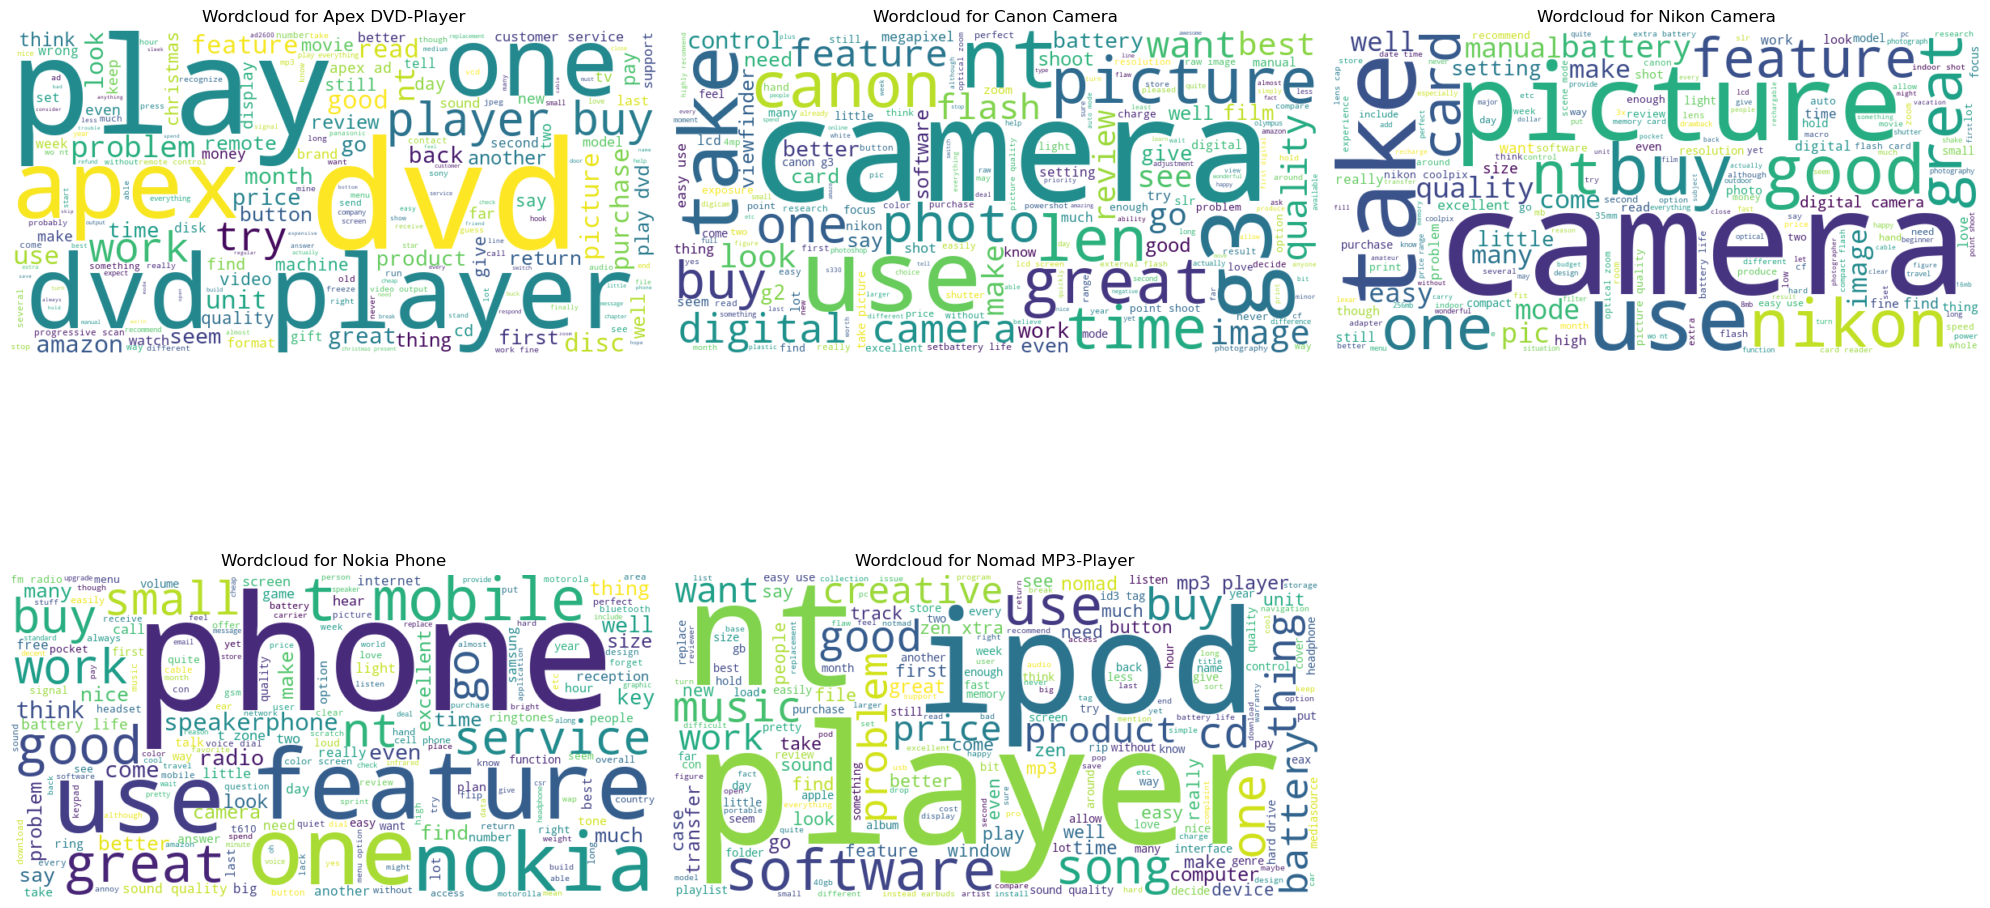

In [49]:
plot_product_wordclouds(remove_stopwords = True, feature_name = 'title')
plt.tight_layout()
plt.show()

##### High Positive word count

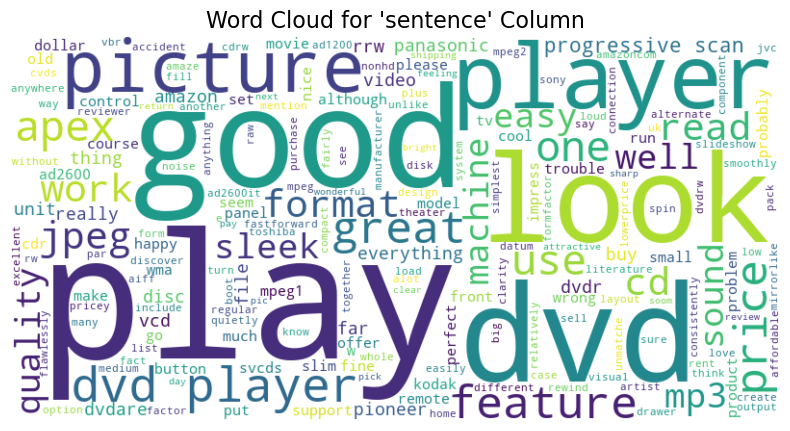

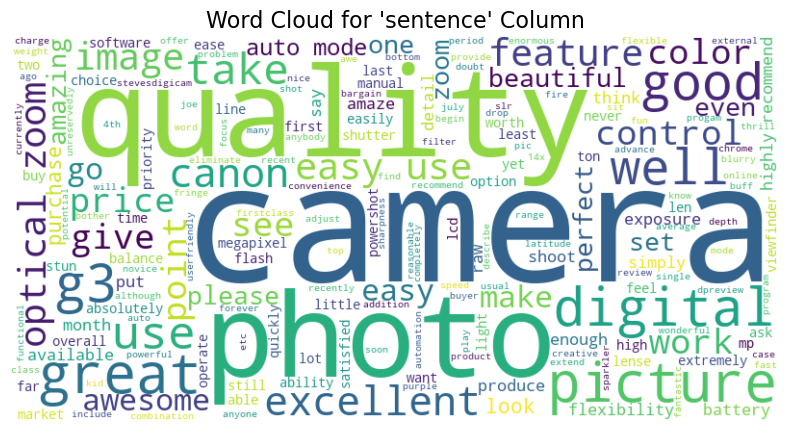

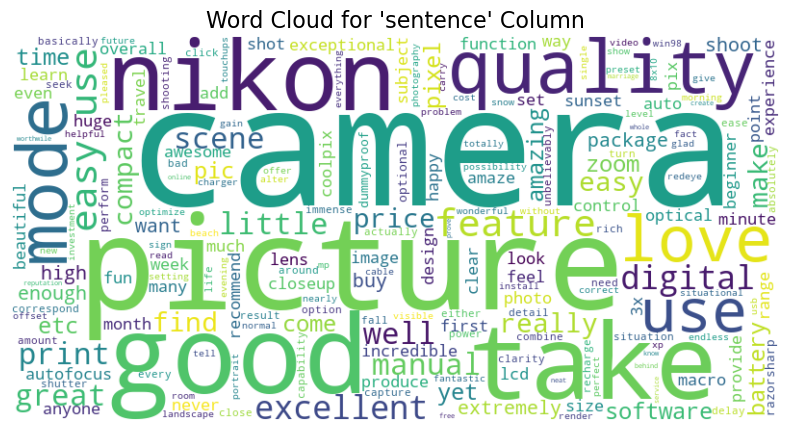

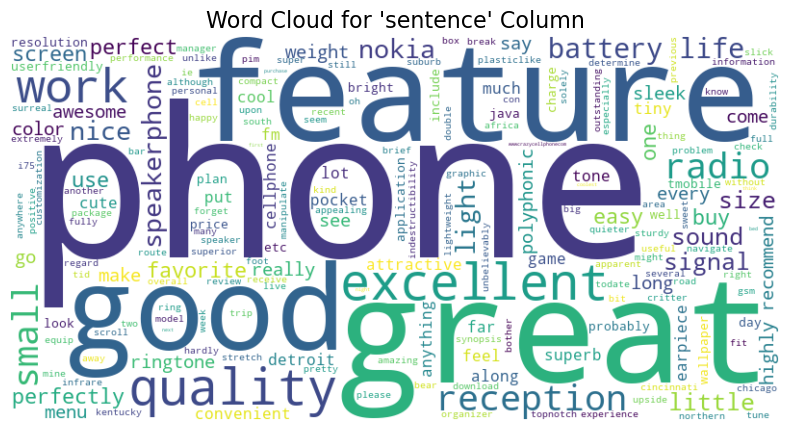

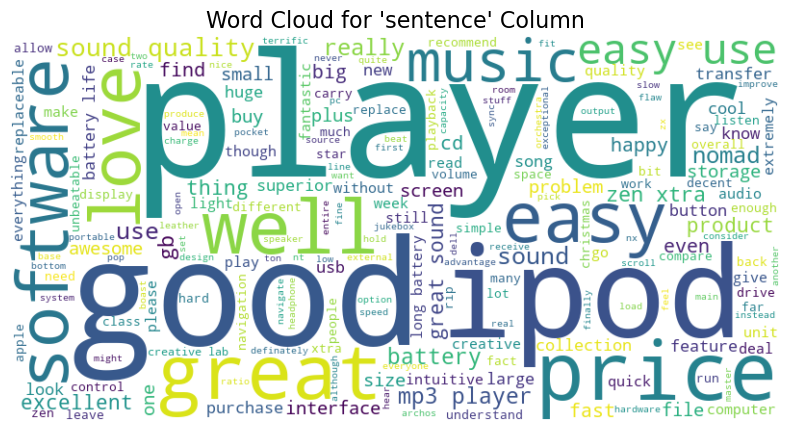

In [ ]:
for product in product_list:
    file_path = f'processed_data\{product}.csv'  # Replace with the actual file path
    data = pd.read_csv(file_path)
    data= data[data['sentiment_total']>=3]
    preprocessed_data = [preprocess_text(text) for text in data['sentence']]
    create_wordcloud(preprocessed_data)

##### Negative Word count

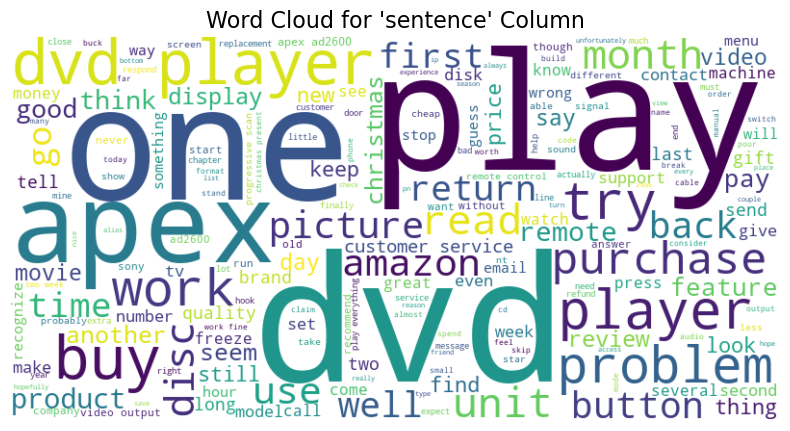

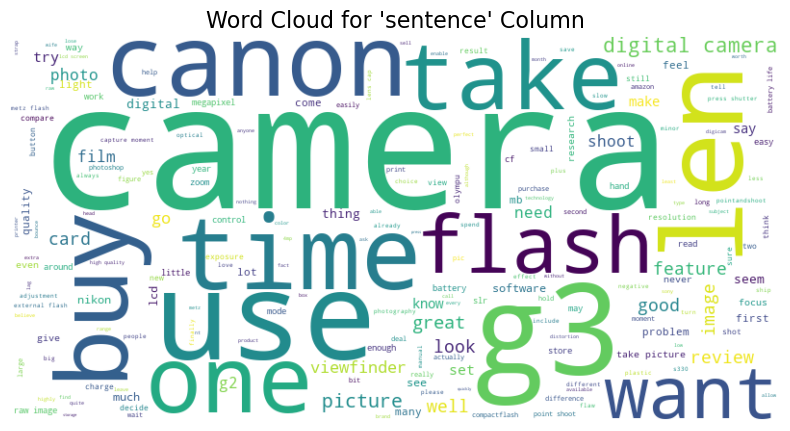

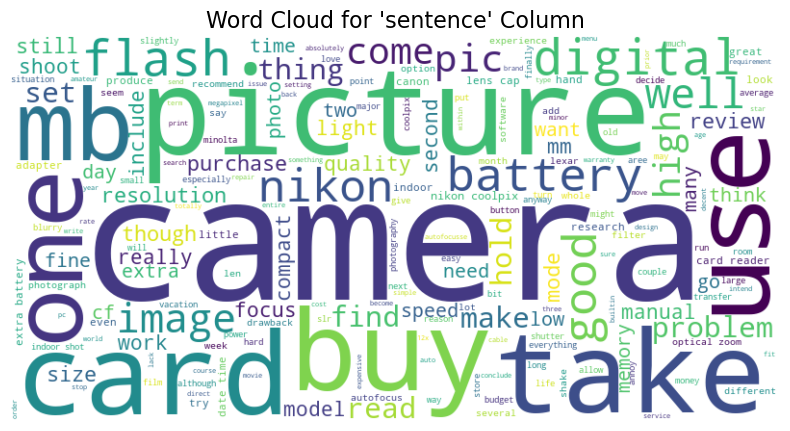

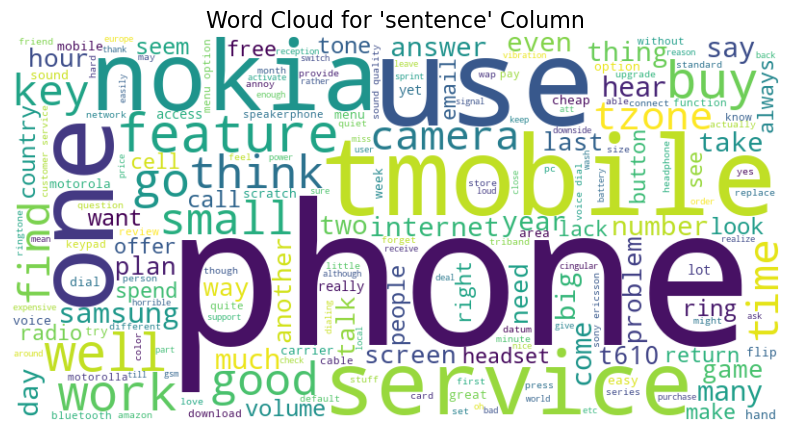

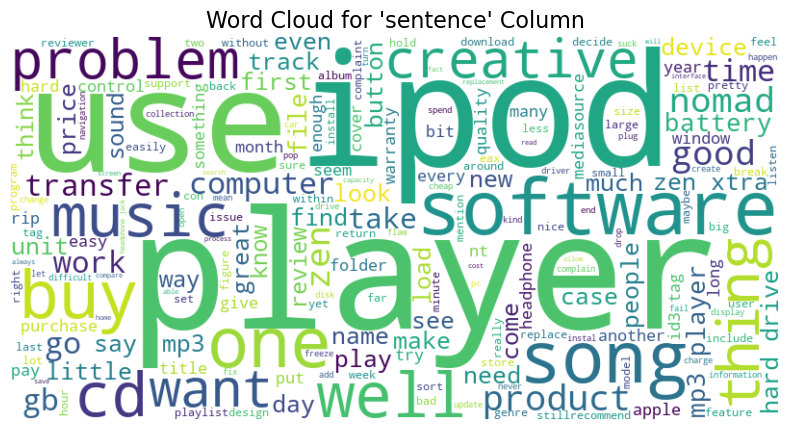

In [68]:
for product in product_list:
    file_path = f'processed_data\{product}.csv'  # Replace with the actual file path
    data = pd.read_csv(file_path)
    data= data[data['sentiment_total']<=0]
    preprocessed_data = [preprocess_text(text) for text in data['sentence']]
    create_wordcloud(preprocessed_data)


### Positive and Negative Sentiment Distribution

In [6]:
def titlewise_analysis(df):
    df_group = (
        df.groupby('title')
        .agg(
            positive_count=('sentiment_total', lambda x: (x > 0).sum()),
            negative_count=('sentiment_total', lambda x: (x < 0).sum()),
            total_count=('sentiment_total', 'count'),
            mean=('sentiment_total', 'mean'),
            Overall_sentiment=('sentiment_total', 'sum'),
        )
        .reset_index()
    )
    df_group.loc[df_group['Overall_sentiment'] > 0, 'Sentiment'] = 'Positive'
    df_group.loc[df_group['Overall_sentiment'] <= 0, 'Sentiment'] = 'Negative'
    return df_group

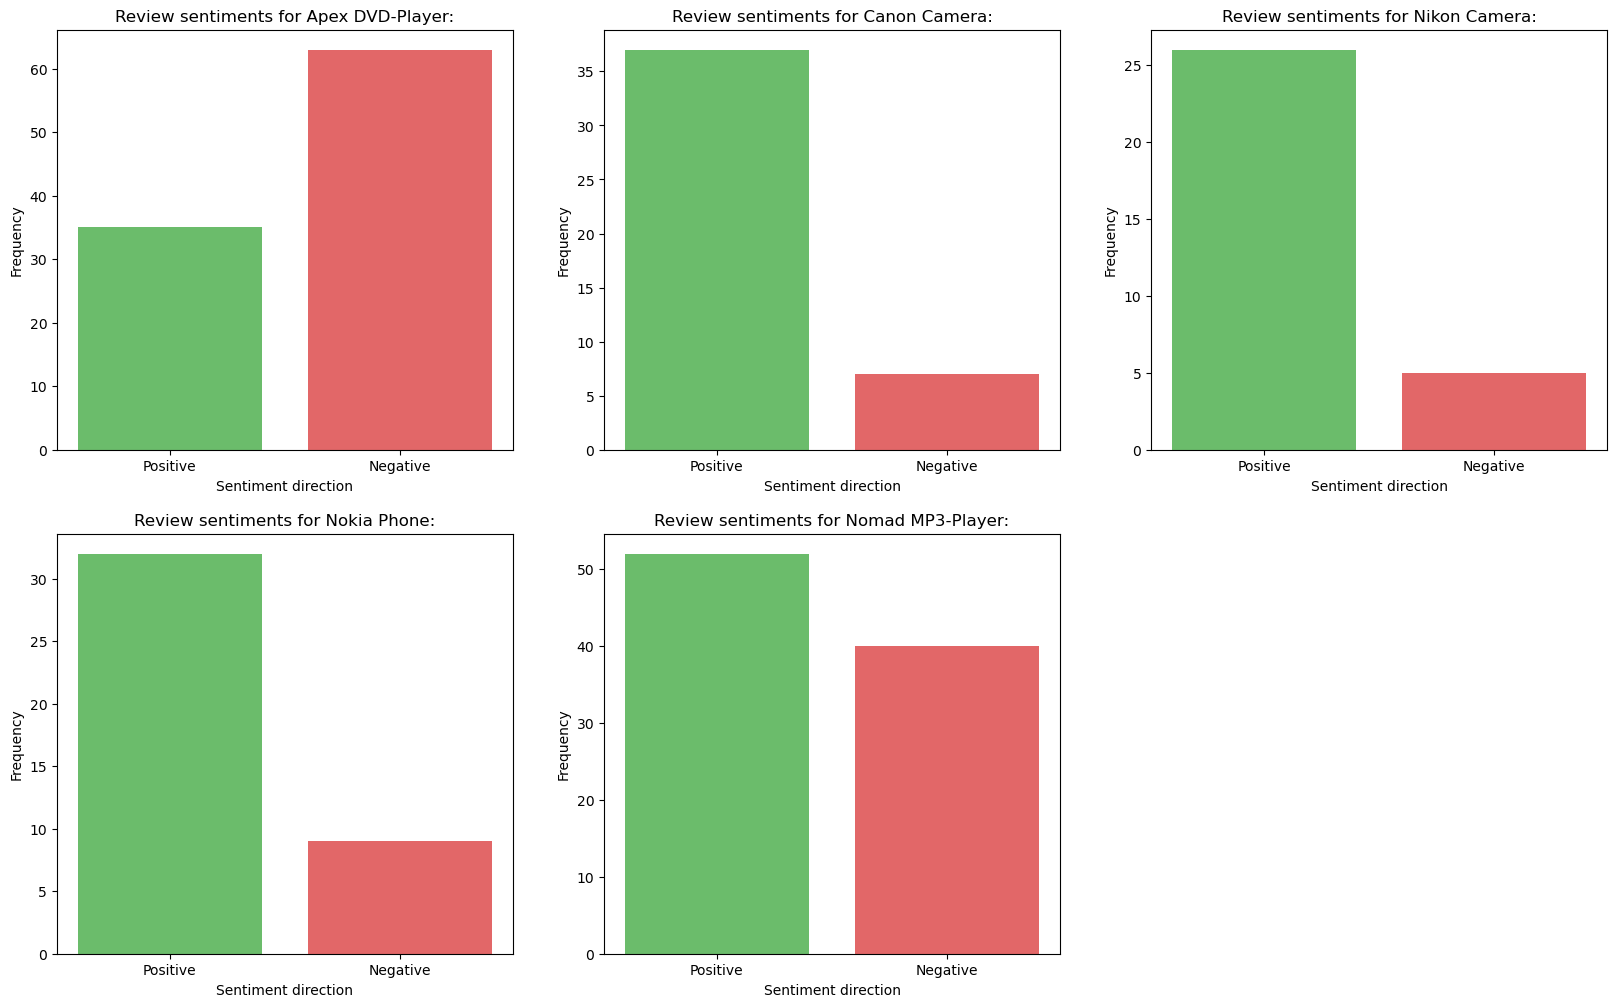

In [7]:
def write_positive_negative_distribution_to_excel():
    with pd.ExcelWriter('Positive_Negative_Distribution.xlsx') as writer:
        for product in product_list:
            file_path = f'processed_data/{product}.csv'
            data = pd.read_csv(file_path)
            data_group= titlewise_analysis(data)
            data_group.to_excel(writer, sheet_name=product, index=False)


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes: list[plt.Axes] = axes.ravel()

for i, product in enumerate(product_list):
    data = pd.read_csv(f'processed_data/{product}.csv')
    sentiment_counts = titlewise_analysis(data)['Sentiment'].value_counts()
    sentiment_counts.sort_index(ascending=False, inplace=True)
    axes[i].bar(x = sentiment_counts.index, height = sentiment_counts.values, color = ['tab:green', 'tab:red'], alpha=0.7)
    axes[i].set_title(f'Review sentiments for {shortened_product_names[product]}:')
    axes[i].set_xlabel('Sentiment direction')
    axes[i].set_ylabel('Frequency')
axes[5].remove()

Text(0.5, 1.0, 'Overall frequency of sentence sentiment directions')

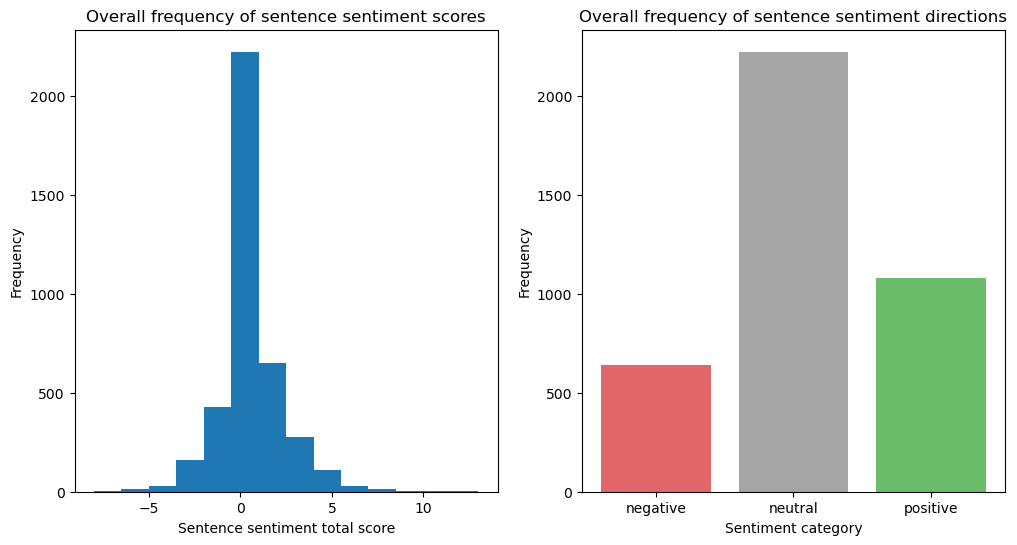

In [9]:
import numpy as np

conditions = [
    master_df['sentiment_total'] > 0,  # Positive sentiment
    master_df['sentiment_total'] < 0,  # Negative sentiment
    master_df['sentiment_total'] == 0  # Neutral sentiment
]
labels = ['positive', 'negative', 'neutral']
master_df['sentiment_category'] = np.select(conditions, labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(master_df['sentiment_total'], bins=14)
axes[0].set_xlabel('Sentence sentiment total score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Overall frequency of sentence sentiment scores')

category_counts = master_df['sentiment_category'].value_counts()
category_counts.sort_index(ascending=True, inplace=True)
axes[1].bar(x = category_counts.index, height = category_counts.values, color = ['tab:red', 'tab:gray', 'tab:green'], alpha=0.7)
axes[1].set_xlabel('Sentiment category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Overall frequency of sentence sentiment directions')

### Distribution of text length

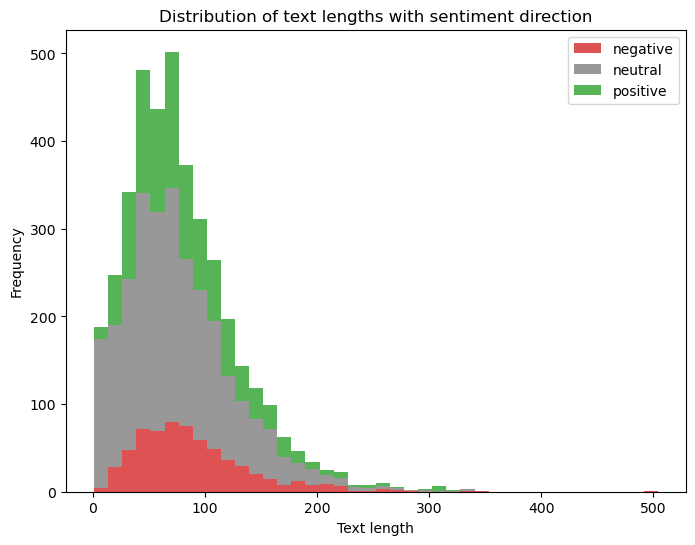

In [35]:
master_df['text_length'] = master_df['sentence'].apply(lambda x: len(str(x)))

color_dict = {"negative": "tab:red", "neutral": "tab:gray", "positive": "tab:green"}
stacked_data = []
for sentiment in color_dict.keys():
    subset = master_df[master_df['sentiment_category'] == sentiment]['text_length']
    stacked_data.append(subset)

plt.figure(figsize=(8, 6))
plt.hist(stacked_data, bins=40, color=list(color_dict.values()), label=list(color_dict.keys()), stacked=True, alpha=0.8)
plt.title('Distribution of text lengths with sentiment direction')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### High Positive Word Distribution

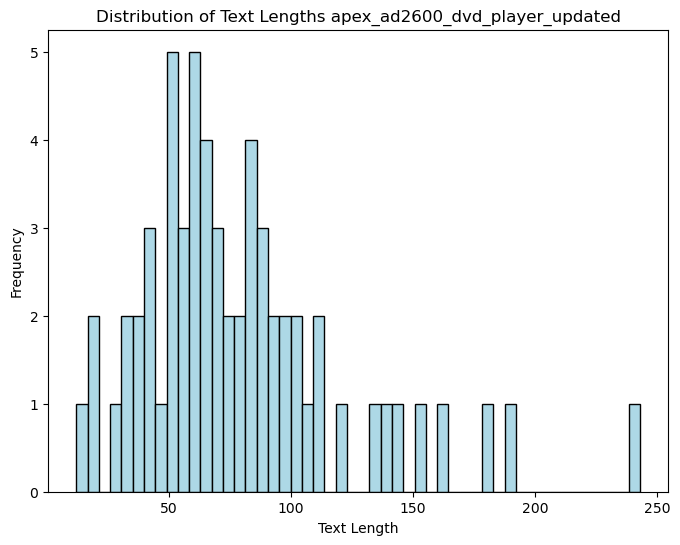

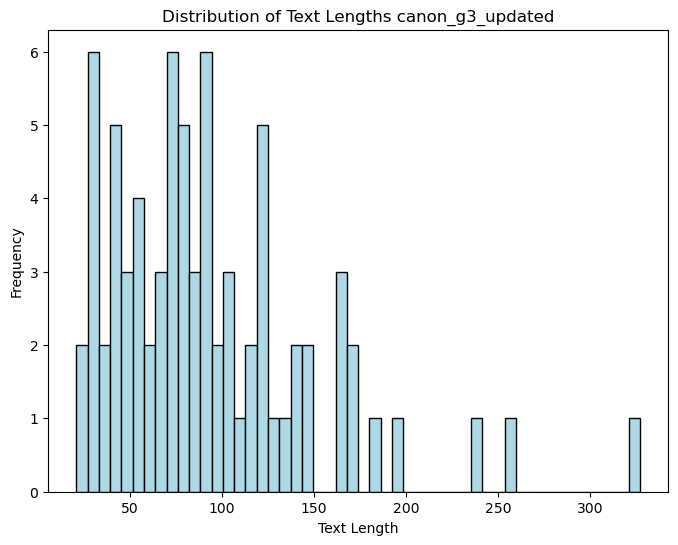

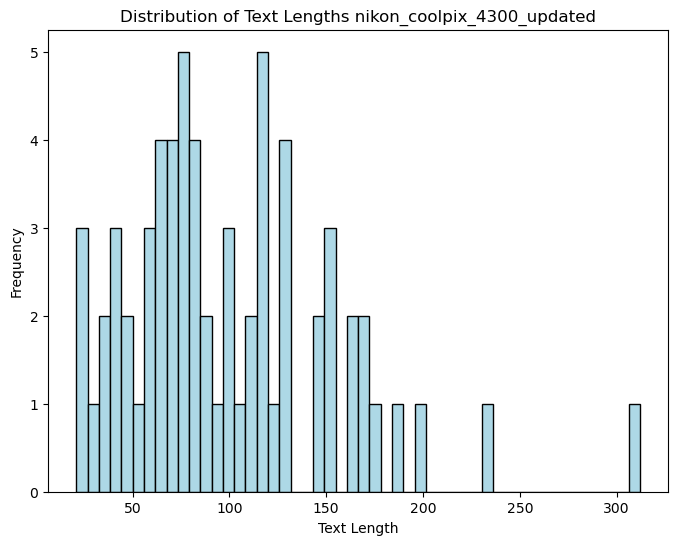

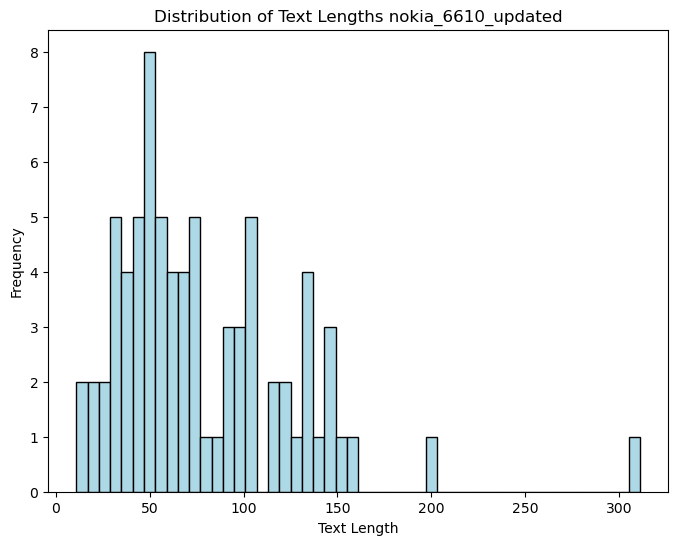

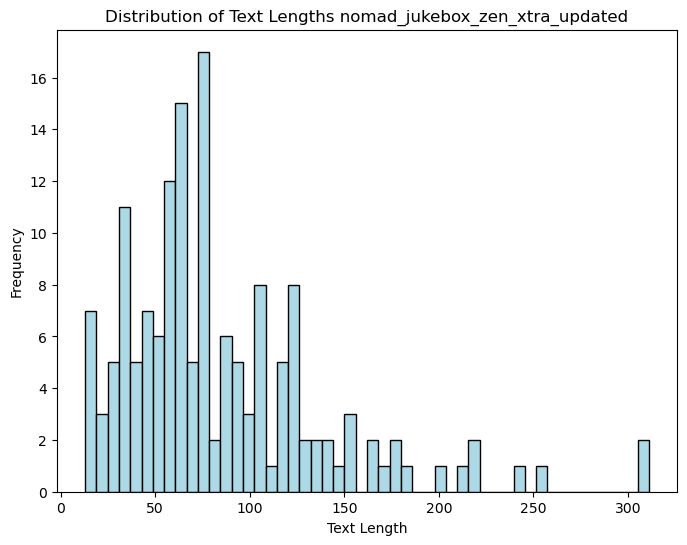

In [69]:
product_list= ['apex_ad2600_dvd_player_updated', 'canon_g3_updated', 'nikon_coolpix_4300_updated', 'nokia_6610_updated', 'nomad_jukebox_zen_xtra_updated']
for product in product_list:
    file_path = f'processed_data\{product}.csv'  # Replace with the actual file path
    data = pd.read_csv(file_path)
    data= data[data['sentiment_total']>=3]
    # Add a column for text length
    data['text_length'] = data['sentence'].apply(lambda x: len(str(x)))
    
    # Plot distribution of text lengths
    plt.figure(figsize=(8, 6))
    plt.hist(data['text_length'], bins=50, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of Text Lengths {product}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()


##### Negative Word Distribution

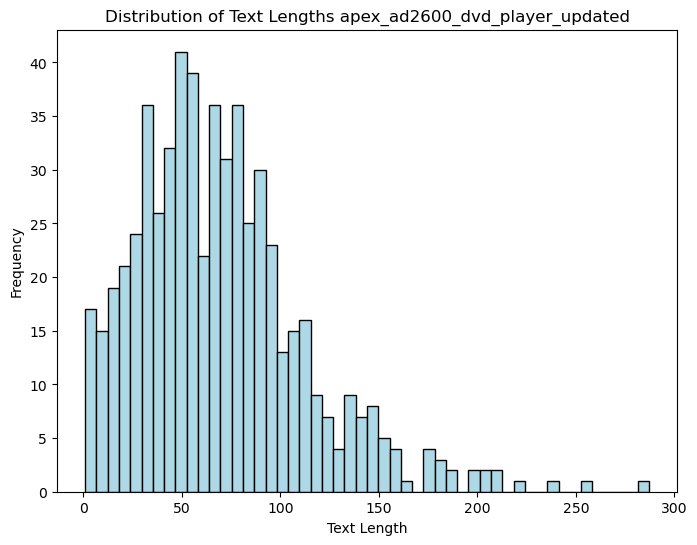

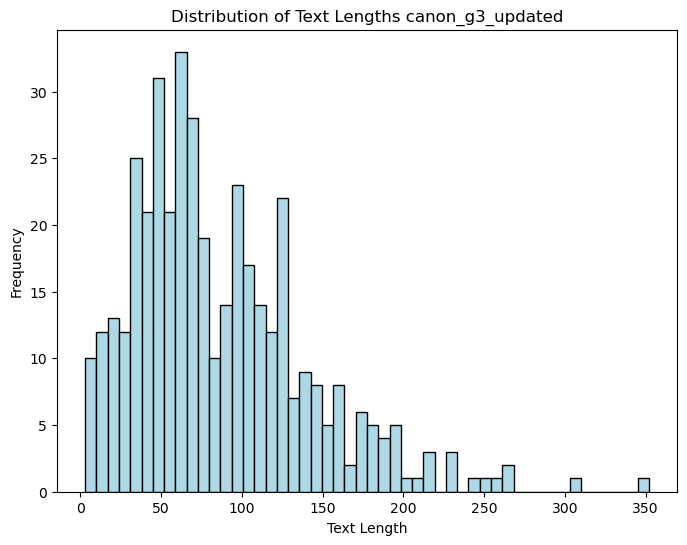

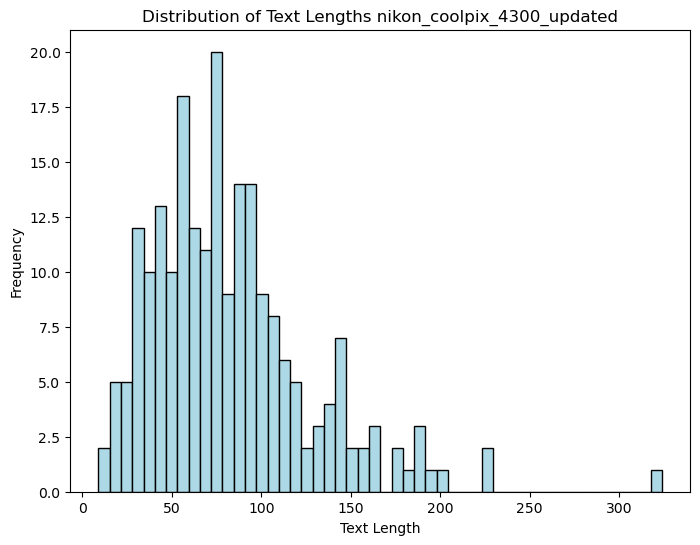

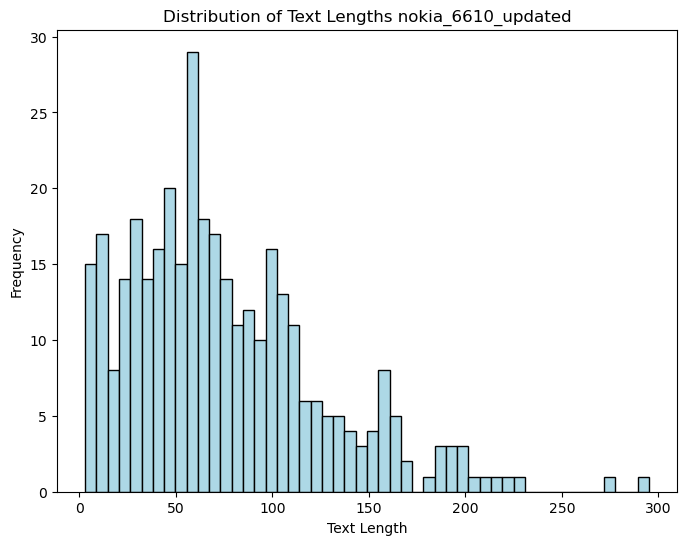

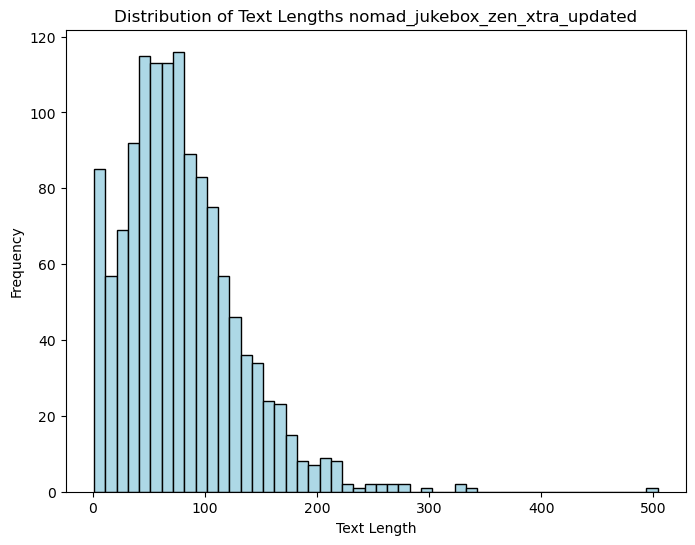

In [72]:
product_list= ['apex_ad2600_dvd_player_updated', 'canon_g3_updated', 'nikon_coolpix_4300_updated', 'nokia_6610_updated', 'nomad_jukebox_zen_xtra_updated']
for product in product_list:
    file_path = f'processed_data\{product}.csv'  # Replace with the actual file path
    data = pd.read_csv(file_path)
    data= data[data['sentiment_total']<=0]
    # Add a column for text length
    data['text_length'] = data['sentence'].apply(lambda x: len(str(x)))
    
    # Plot distribution of text lengths
    plt.figure(figsize=(8, 6))
    plt.hist(data['text_length'], bins=50, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of Text Lengths {product}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()


### Parts of Speech (Need to understand what to do with this analysis)

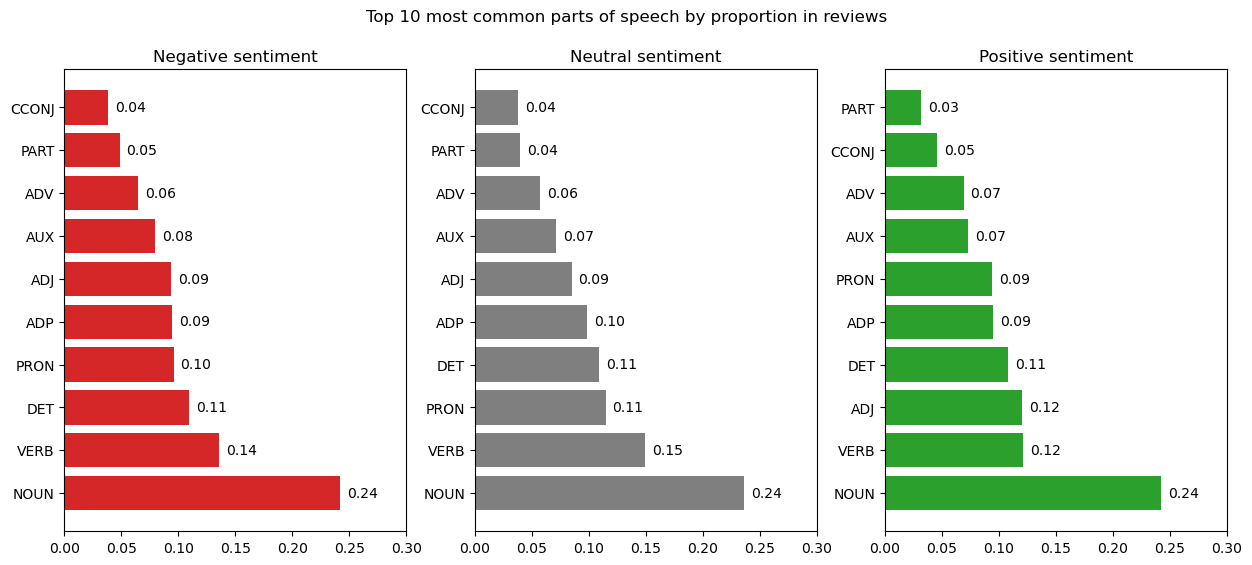

In [63]:
negative_doc = nlp(master_df[master_df['sentiment_category'] == 'negative']['sentence'].apply(lambda x: str(x)).sum())
neutral_doc = nlp(master_df[master_df['sentiment_category'] == 'neutral']['sentence'].apply(lambda x: str(x)).sum())
positive_doc = nlp(master_df[master_df['sentiment_category'] == 'positive']['sentence'].apply(lambda x: str(x)).sum())

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes: list[plt.Axes] = axes
fig.suptitle('Top 10 most common parts of speech by proportion in reviews')

negative_pos_tags = [token.pos_ for token in negative_doc]
neutral_pos_tags = [token.pos_ for token in neutral_doc]
positive_pos_tags = [token.pos_ for token in positive_doc]

negative_pos_tags = pd.DataFrame(FreqDist(negative_pos_tags).most_common(10), columns=['Part of Speech', 'Frequency'])
neutral_pos_tags = pd.DataFrame(FreqDist(neutral_pos_tags).most_common(10), columns=['Part of Speech', 'Frequency'])
positive_pos_tags = pd.DataFrame(FreqDist(positive_pos_tags).most_common(10), columns=['Part of Speech', 'Frequency'])

total_negative_pos_tags = negative_pos_tags['Frequency'].sum()
total_neutral_pos_tags = neutral_pos_tags['Frequency'].sum()
total_positive_pos_tags = positive_pos_tags['Frequency'].sum()
negative_pos_tags['Proportion'] = negative_pos_tags['Frequency'] / total_negative_pos_tags
neutral_pos_tags['Proportion'] = neutral_pos_tags['Frequency'] / total_neutral_pos_tags
positive_pos_tags['Proportion'] = positive_pos_tags['Frequency'] / total_positive_pos_tags

negative_bars = axes[0].barh(negative_pos_tags['Part of Speech'], negative_pos_tags['Proportion'], color='tab:red')
neutral_bars = axes[1].barh(neutral_pos_tags['Part of Speech'], neutral_pos_tags['Proportion'], color='tab:gray')
positive_bars = axes[2].barh(positive_pos_tags['Part of Speech'], positive_pos_tags['Proportion'], color='tab:green')

axes[0].bar_label(negative_bars, fmt='%.2f', padding=5)
axes[1].bar_label(neutral_bars, fmt='%.2f', padding=5)
axes[2].bar_label(positive_bars, fmt='%.2f', padding=5)

axes[0].set_title('Negative sentiment')
axes[1].set_title('Neutral sentiment')
axes[2].set_title('Positive sentiment')

axes[0].set_xlim(0, 0.30)
axes[1].set_xlim(0, 0.30)
axes[2].set_xlim(0, 0.30)

plt.show()

# Bigrams Network Graphs

Positive reviews

638
[(('dvd', 'player'), 16), (('customer', 'service'), 11), (('nt', 'play'), 10), (('wo', 'nt'), 10), (('headphone', 'jack'), 10), (('3', 'month'), 8), (('scroll', 'button'), 8), (('hard', 'drive'), 8), (('play', 'dvd'), 7), (('nt', 'work'), 7)]


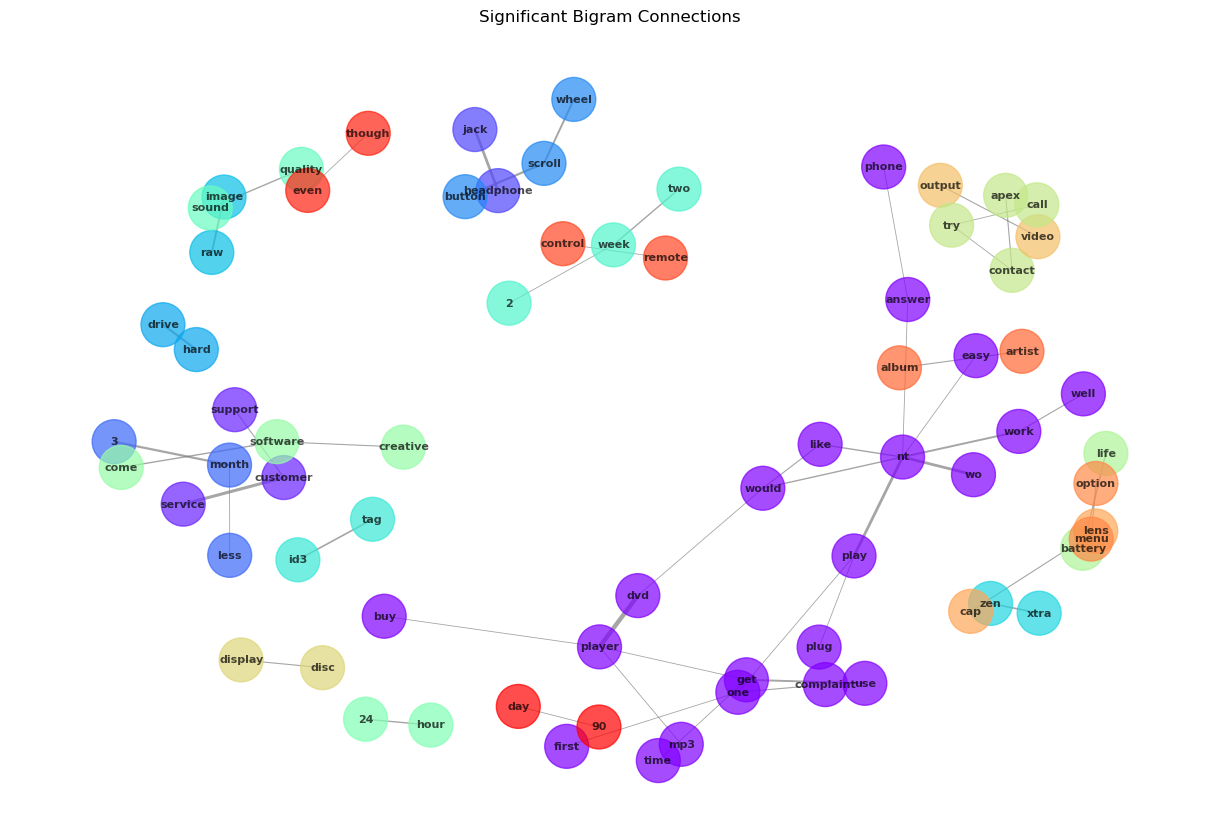

In [29]:
def plot_bigram_word_network(tokenized_reviews: pd.Series) -> plt.Figure:
    def create_network_visualization(bigrams, min_freq=2, max_edges=50) -> nx.Graph:
        G = nx.Graph() # Initialize a graph object
        
        for (w1, w2), freq in bigrams.items(): # Add edges
            if freq >= min_freq:
                G.add_edge(w1, w2, weight=freq)
        
        if len(G.edges()) > max_edges: # Limit to most significant connections to avoid over cluttering
            significant_edges = sorted(G.edges(data=True), 
                                    key=lambda x: x[2]['weight'], 
                                    reverse=True)[:max_edges]
            G = nx.Graph()
            for w1, w2, data in significant_edges:
                G.add_edge(w1, w2, weight=data['weight'])
        
        return G

    def plot_word_network(G):
        plt.figure(figsize=(12, 8))

        # Tested multiple different layouts, these were the best configurations, each with their own merit
        # pos = nx.planar_layout(G, scale=1.3)
        # pos = nx.arf_layout(G, a=1.5, max_iter = 100)
        pos = nx.spring_layout(G, k=1.1, iterations=100, scale=0.5)

        thickness_weight = 1 / 5  # Multiplying by a scalar adjust the edge thickness
        edge_weights = [G[u][v]["weight"] * thickness_weight for u, v in G.edges()]

        
        clusters = list(nx.connected_components(G))
        colors = cm.rainbow(np.linspace(0, 1, len(clusters))) 

        # Coloring clusters to make things a bit easier to differentiate
        node_color_map = {}
        for color, cluster in zip(colors, clusters):
            for node in cluster:
                node_color_map[node] = color

        node_colors = [node_color_map[node] for node in G.nodes()]

        # Plot
        nx.draw(G, pos,
                node_color=node_colors,
                node_size=1000,
                font_size=8,
                font_weight='bold',
                width=edge_weights,
                with_labels=True,
                edge_color='gray',
                alpha=0.7)

        plt.title("Significant Bigram Connections")
        return plt.gcf()

    n_grams = []
    for tokens in tokenized_reviews.values:
        n_grams += list(ngrams(tokens, 2))
    freq_dist_ngrams = FreqDist(n_grams)
    print(freq_dist_ngrams.most_common(10))

    G = create_network_visualization(freq_dist_ngrams, min_freq=2, max_edges=50)
    fig = plot_word_network(G)
    return fig

negative_observations = master_df[master_df['sentiment_category'] == 'negative']
print(negative_observations.__len__())
_ = plot_bigram_word_network(negative_observations['sentence'].apply(preprocess_text))
# _ = plot_bigram_word_network(master_df['sentence'].dropna().apply(preprocess_text))

Negative reviews

1082
[(('easy', 'use'), 43), (('battery', 'life'), 30), (('sound', 'quality'), 29), (('dvd', 'player'), 22), (('mp3', 'player'), 20), (('digital', 'camera'), 16), (('zen', 'xtra'), 15), (('picture', 'quality'), 13), (('highly', 'recommend'), 11), (('!', '!'), 10)]


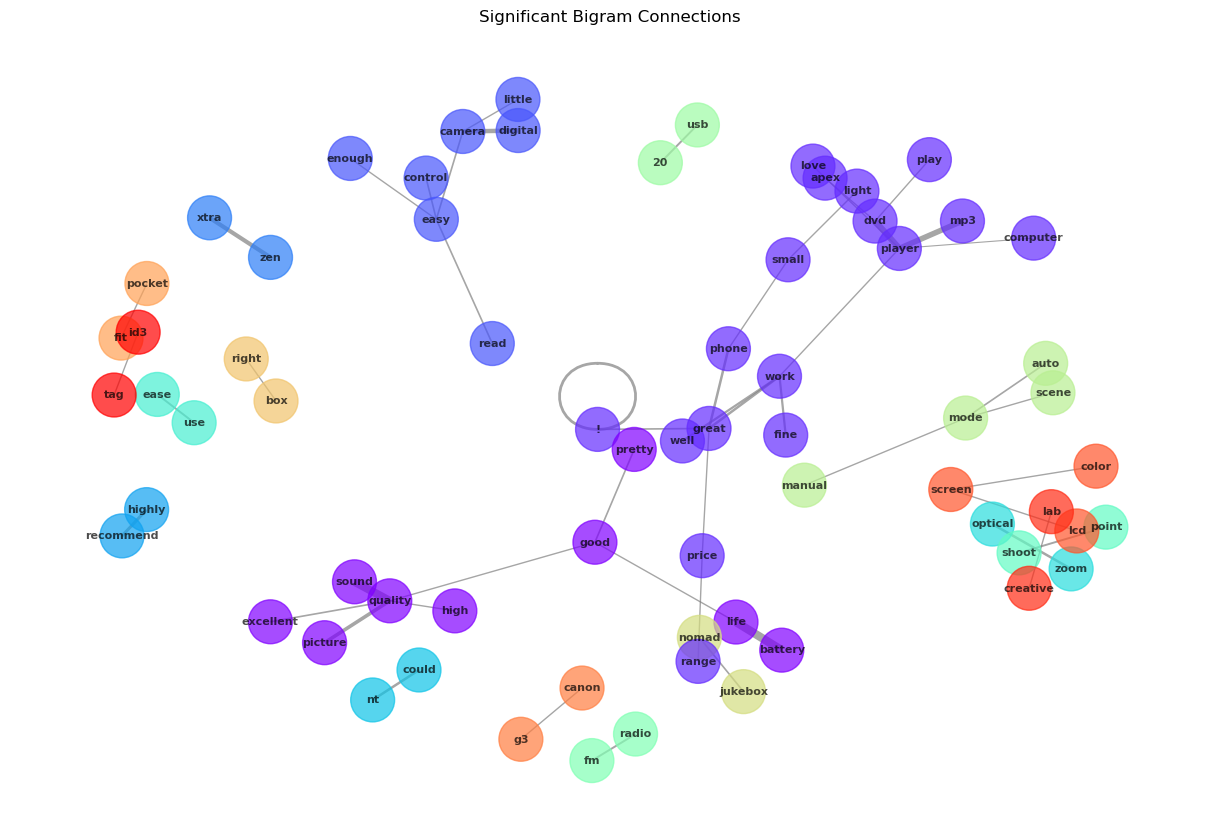

In [30]:
positive_observations = master_df[master_df['sentiment_category'] == 'positive']
print(positive_observations.__len__())
_ = plot_bigram_word_network(positive_observations['sentence'].apply(preprocess_text))